# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [50]:
%matplotlib inline
import pandas as pd 
import numpy as np

In [2]:
titles = [] # list of news titles
categories = [] # list of news categories
labels = [] # list of different categories (without repetitions)
nlabels = 4 # number of different categories
lnews = [] # list of dictionaries with two fields: one for the news and 
            # the other for its category

In [7]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip *.zip

--2019-01-07 10:50:53--  http://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/zip]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M   396KB/s    in 2m 5s   

2019-01-07 10:52:59 (228 KB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [23]:
!cat readme.txt | grep -E "(FORMAT|FILENAME)"

FORMAT: Tab delimited CSV files. 
FILENAME #1: newsCorpora.csv (102.297.000 bytes)
FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
FILENAME #2: 2pageSessions.csv (3.049.986 bytes)
FORMAT: STORY \t HOSTNAME \t CATEGORY \t URL


In [55]:
def import_data():
    global titles, labels, categories
    # importing news aggregator data via Pandas (Python Data Analysis Library)
    colnames = ['Id', 'Title', 'Url', 'Publisher', 'Category', 'Story', 'Hostname', 'Timestamp']
    dtypes = [np.uint64, np.character, np.character, np.character, np.object, np.character, np.character, np.int64]
    col_dtypes = {col: t for col, t in zip(colnames, dtypes)}
    news = pd.read_table("./newsCorpora.csv", dtype=col_dtypes, names=colnames, header=None, sep='\t')
    # function 'head' shows the first 5 items in a column (or
    # the first 5 rows in the DataFrame)
    categories = news['Category']
    labels = sorted(list(set(categories)))
        
    return labels, news

In [60]:
categories, df = import_data()

In [65]:
from collections import Counter

def count_data(labels,categories):    
    c = Counter(categories)
    cont = dict(c)
    # total number of news
    tot = sum(list(cont.values()))     
    d = {
        "category" : labels,
        "news" : [cont[l] for l in labels],
        "percent" : [cont[l]/tot for l in labels]
    }
   
    print(pd.DataFrame(d))   
    print("total \t",tot) 
    
    return cont

cont = count_data(categories, df['Category'])

  category    news   percent
0        b  115967  0.274531
1        e  152469  0.360943
2        m   45639  0.108042
3        t  108344  0.256485
total 	 422419


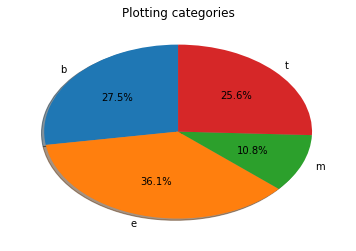

In [76]:
import pylab as pl # useful for drawing graphics

def categories_pie_plot(labels, cont, tit):
    sizes = [cont[l] for l in labels]
    pl.pie(sizes, explode=(0, 0, 0, 0), labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=90)
    pl.title(tit)
    pl.show()
    
categories_pie_plot(categories, cont,"Plotting categories")

In [72]:
from sklearn.utils import shuffle # Shuffle arrays in a consistent way

def split_data(titles, categories):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    N = len(titles)
    Ntrain = int(N * 0.7)    
    # Let's shuffle the data
    titles, categories = shuffle(titles, categories, random_state=0)
    X_train = titles[:Ntrain]
    y_train = categories[:Ntrain]
    X_test = titles[Ntrain:]
    y_test = categories[Ntrain:]
    
    return X_train, y_train, X_test, y_test

X_tr, y_tr, X_te, y_te = split_data(df['Title'], df['Category'])

In [74]:
cont2 = count_data(categories, y_tr)

  category    news   percent
0        b   81238  0.274738
1        e  106844  0.361334
2        m   31930  0.107984
3        t   75681  0.255945
total 	 295693


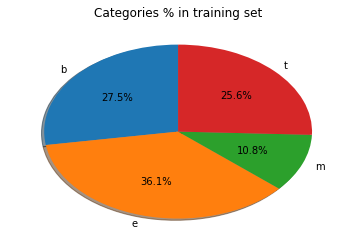

In [78]:
categories_pie_plot(categories, cont2,"Categories % in training set")

In [84]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline 
from sklearn import metrics 
import numpy as np
import pprint

def train_test(X_tr, y_tr, X_te, y_te, labels):
    # 1. Tokenize the titles
    # 2. Score each token by tf-idf frequency - which
    #    gives a weight to each token according to its
    #    frequency, scaled by the degree to which the term
    #    does not occur. 
    # 3. Estimate final weights using naive bayes 
    #    (opaque to me at the moment)
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB()),
                         ])
    
    # Fit the training set
    text_clf = text_clf.fit(X_tr, y_tr)
    
    # Predict using the test set
    predicted = text_clf.predict(X_te)
    
    return predicted

In [87]:
test_set_predictions = train_test(X_tr, y_tr, X_te, y_te, categories)

In [88]:
metrics.accuracy_score(y_te, test_set_predictions)

0.9238041128103152

In [92]:
print(metrics.classification_report(y_te, test_set_predictions, target_names=categories))

             precision    recall  f1-score   support

          b       0.90      0.91      0.90     34729
          e       0.95      0.97      0.96     45625
          m       0.97      0.85      0.90     13709
          t       0.90      0.90      0.90     32663

avg / total       0.92      0.92      0.92    126726



In [95]:
mat = metrics.confusion_matrix(y_te, test_set_predictions, labels=categories)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
cm

array([[0.91004636, 0.02361139, 0.00552852, 0.06081373],
       [0.01176986, 0.97192329, 0.00192877, 0.01437808],
       [0.06200306, 0.06193012, 0.84601357, 0.03005325],
       [0.06778312, 0.02510486, 0.00324526, 0.90386676]])

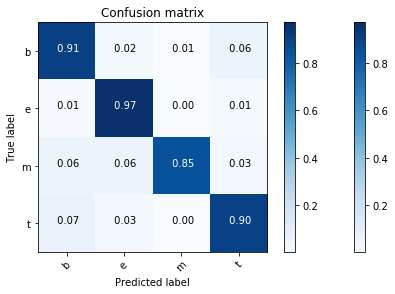

In [99]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:5.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.show()

plot_confusion_matrix(cm, categories, title='Confusion matrix')

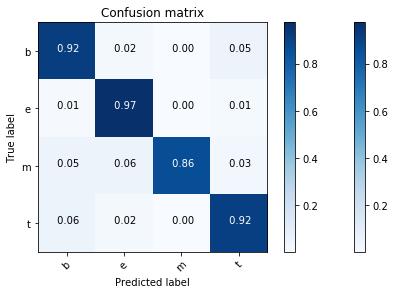

In [101]:
# Conversely we should expect near perfect predictions to the training
# set which gives us a sense of how well fit the model is

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
    
# Fit the training set
text_clf = pipeline.fit(X_tr, y_tr)

# Predict using the test set
predicted = text_clf.predict(X_tr)

mat = metrics.confusion_matrix(y_tr, predicted, labels=categories)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cm, categories, title='Confusion matrix')

In [98]:
def resume_data(labels,y_train,f1s):
    c = Counter(y_train)
    cont = dict(c)
    tot = sum(list(cont.values()))
    nlabels = len(labels)
    d = {
        "category" : [labels[i] for i in range(nlabels)],
        "percent" : [cont[labels[i]]/tot for i in range(nlabels)],
        "f1-score" : [f1s[i] for i in range(nlabels)]
    }
   
    print(pd.DataFrame(d))   
    print("total \t",tot) 
    return cont

f1s = metrics.f1_score(y_te, test_set_predictions, labels=categories, average=None)
cont3 = resume_data(categories,y_tr,f1s)

  category   percent  f1-score
0        b  0.274738  0.903839
1        e  0.361334  0.959225
2        m  0.107984  0.902814
3        t  0.255945  0.903314
total 	 295693


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

I chose to replicate the "[Using genetic algorithms to solve the traveling salesperson problem](https://nbviewer.jupyter.org/github/lmarti/evolutionary-computation-course/blob/master/AEC.03%20-%20Solving%20the%20TSP%20with%20GAs.ipynb)" notebook, which necessairily the "[Elements of Evolutionary Algorithms](https://nbviewer.jupyter.org/github/lmarti/evolutionary-computation-course/blob/master/AEC.02%20-%20Elements%20of%20Evolutionary%20Algorithms.ipynb)" notebook as a prerequisite. 


The first notebook goes about describing evolutionary algorithms as composed of:
 - A fitness function, which determines how fit an organism is to it's enviornment
 - A poset (partial ordering) over the application of the fitness function to the population
   at hand
 - A mating process where all individuals in the population procreate using the fitness  
   function
 - A source of variation which determines how we combine some number of mating members from
   the population to generate offspring
 - A stop condition, where some goal was reached allowing the algorithm to terminate

In [ ]:
!pip install deap

In [191]:
import random
from deap import algorithms, base, creator, tools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

In [192]:
# Creates a class called FitnessMax which inherits from base.Fitness 
# and has all successive kwargs as attributes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Creates a class called Inidividual which inherits from list and
# has the attribute fitness set to the creator.FitnessMax constructor
creator.create("Individual", list, fitness=creator.FitnessMax)

/Users/work/.pyenv/versions/3.6.4/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [193]:
# Here we take an individual (a list) and sum it, returning the sum in the
# left of a 2-tuple
def evalOneMax(individual):
    return (sum(individual),)

In [194]:
# base.Toolbox is an abstract base layer to most of the other 'Toolboxes' provided
# by DEAP. On it's own it doesn't provide much support, but is useful for DRY reasons

toolbox = base.Toolbox()

# Adding various attributes to our custom toolbox class, for example the first is a
# function which randomly returns 0 or 1 with uniform probability
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [195]:
# To demonstrate, this generates a list - randomly - of 0s and 1s
n = 50
zeros_and_ones = [toolbox.attr_bool() for _ in range(n)]
ones_and_zeros = [toolbox.attr_bool() for _ in range(n)]

# These could be equal, but it's a low probability
ones_and_zeros == zeros_and_ones

False

In [196]:
# toolbox.individual is a function which runs the toolbox.attr_bool function 100 times
# and aggregates the results into a creator.Individual instance
list_of_0s_and_1s = toolbox.individual()
type(list_of_0s_and_1s), type(list_of_0s_and_1s[0]), len(list_of_0s_and_1s)

(deap.creator.Individual, int, 100)

In [197]:
# toolbox.population is just like toolbox.indiviudal but instead of running toolbox.attr_bool,
# it runs toolbox.individual, hence generating a matrix! But! Because the n kwarg was not
# specifiec for us, we have to include it ourselves, to keep things consistent we'll make it
# 100
pop = toolbox.population(n=100)
type(pop), type(pop[0]), len(pop), len(pop[0])

(list, deap.creator.Individual, 100, 100)

In [198]:
toolbox.evaluate(list_of_0s_and_1s)

(57,)

In [199]:
from random import sample

indv1 = sample(pop, k=1)[0]
indv2 = sample(pop, k=1)[0]

genes = toolbox.mate(indv1, indv2)

# Genes in a pair, oddly simple
genes[0] == indv1, genes[1] == indv2

(True, True)

In [200]:
# Randomly flip bits in the genes with probability 0.05 as denoted above
toolbox.mutate(indv1) == indv1

False

In [207]:
# Using the selTournament function k members of the population survive as chosen at
# random using the choice function from the random module

# Only one shall live!!
survivor = toolbox.select(genes, k=1)

len(survivor), len(survivor[0]), type(survivor[0])

(1, 100, deap.creator.Individual)

In [208]:
pop = toolbox.population(n=300)

# algorithms.eaSimple takes the following as arguments:
#   - Our 'toolbox' which has the predefined evolution operators available
#   - a probability of mating two indiviudals, here it's 0.5 as given by the kwarg cxpb
#   - a probability of mutating an individual, here it's 0.5 as given by the kwarg mutpb
#   - the number of generations to run (ngen), here it's 10
#   - wether the class should log statistics
result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=False)

# Finally we select the k best individuals, here 1, and print the one which maximizes
# the fitness function given by the 'evaluate' property of toolbox, here set to the
# evalOneMax function. We then spit out the individual which maximized that function
# and run evalOneMax again to show what the fitness of that individual was!
print('Current best fitness:', evalOneMax(tools.selBest(pop, k=1)[0]))

# Here we do the same as above but we increase the population size
result = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
print('Current best fitness:', evalOneMax(tools.selBest(pop, k=1)[0]))

Current best fitness: (78,)
Current best fitness: (100,)


In [213]:
# Now we do the same things as above but we make each individual in the population more 
# complex by giving it, literally, more bits of information, and we _minimize_ the given
# fitness function. Note, that while the length of each individual is now much smaller,
# the individuals are in fact more complex because the space of possible value combinations
# an individual can occupy is much grander.

IND_SIZE = 5

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("MoreComplexIndividual", list, fitness=creator.FitnessMin)

toolbox1 = base.Toolbox()
toolbox1.register("attr_float", random.random)
toolbox1.register("individual", tools.initRepeat, creator.Individual, toolbox1.attr_float, n=IND_SIZE)

In [232]:
ind1 = toolbox1.individual()
print(ind1)
print(ind1.fitness) # empty
print(ind1.fitness.valid)

[0.9675405683096411, 0.884144051690612, 0.8961236343122323, 0.9807478882235938, 0.5868434162223263]
()
False


In [233]:
# We create a custom fitness function, which simply returns the sum of an individuals genes

def evaluate(individual):
    # Do some hard computing on the individual
    a = sum(individual)
    b = len(individual)
    return a, 1. / b

In [234]:
ind1.fitness.values = evaluate(ind1)
print(ind1)
print(ind1.fitness)
print(ind1.fitness.valid)

[0.9675405683096411, 0.884144051690612, 0.8961236343122323, 0.9807478882235938, 0.5868434162223263]
(4.315399558758405,)
True


In [278]:
# Here our mutation functions the same as the one before, save for the underlying
# probability distribution and hence the outcomes. Note that mu and sigma are the canonical
# parameters to a normal distribution indicating mean and standard deviation respectively

mutant = toolbox1.clone(ind1)
ind2 = tools.mutGaussian(mutant, mu=0.0, sigma=0.2, indpb=0.2)[0]
del mutant.fitness.values

In [279]:
# As you can see not all values are changed 
mutant, ind1, mutant in ind1

([0.9730041215501521,
  0.7082164022377274,
  0.8381814863828563,
  0.9807478882235938,
  0.5548593276292938],
 [0.9675405683096411,
  0.884144051690612,
  0.8961236343122323,
  0.9807478882235938,
  0.5868434162223263],
 False)

In [281]:
# Crossover only mates individuals

child1, child2 = [toolbox1.clone(ind) for ind in (ind1, ind2)]
tools.cxBlend(child1, child2, 0.5)
del child1.fitness.values
del child2.fitness.values

In [293]:
selected = tools.selBest([child1, child2], 2)
child1, selected, child1 == selected[0]

([0.9651732120183844,
  0.8976390097971761,
  0.840683051443318,
  0.9807478882235938,
  0.5653461954759831],
 [[0.9651732120183844,
   0.8976390097971761,
   0.840683051443318,
   0.9807478882235938,
   0.5653461954759831],
  [0.9753714778414089,
   0.6947214441311633,
   0.8936220692517706,
   0.9807478882235938,
   0.576356548375637]],
 True)

The second notebook is on how to solve the Traveling Salesman Problem using DEAP

In [295]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random, operator, time, itertools, math
import numpy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

In [297]:
# As with any algorithm we need a good representation of the data we're going to manipulate
# to solve the Traveling Salesman Problem (TSP) we can represent the points we'll be traveling
# between with unique ids, and the path between them as tuples containing those points.
# Hence the tuple (1,8,4) indicates we want to travel to point 1, 8, and 4 in some order.

# We can quickly get all permutations (all possible routes betwene the points), one (or more)
# of which must be the shortest. 
points = (1,6,4)
list(itertools.permutations(points))

[(1, 6, 4), (1, 4, 6), (6, 1, 4), (6, 4, 1), (4, 1, 6), (4, 6, 1)]

In [298]:
# The only thing differentiating any of these permutations from one another is the distance
# between each point therein, thus we need some notion of distance. This might be the cost
# to get between the points, the physical distance, the amount of time, etc. I like how the
# notebook implements the notion of a point with distance:
City = complex

# Hence we can use normal mathematical notations of distance!
def distance(A, B): 
    "The Euclidean distance between two cities."
    return abs(A - B)

A = City(300, 0)
B = City(0, 400)
distance(A, B)

500.0

In [300]:
# All that's left now is to assign a notion of distance to each point! It makes sense
# to generate a random dataset to this end for convenience, the notebook defines one
# below:
def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    return set(City(random.randrange(10, 890), random.randrange(10, 590)) for c in range(n))

In [326]:
n = 10
cities = generate_cities(n)
len(cities) # not all points are unique, and hence some are excluded

10

In [327]:
# Given a list of points in the complex plane find the distance between all adjacent
# points
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) for i in range(len(tour)))

# 
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

# Use matplotlib to plot a line between two points
def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    
    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)

# 
def plot_tour(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles, and the starting city as a red square.
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    # plt.show()

In [328]:
def shortest(tours): 
    "Return the tour with the minimum total distance."
    return min(tours, key=total_distance)

def exact_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(itertools.permutations(cities))

In [329]:
%time tour = exact_TSP(cities)

CPU times: user 24.5 s, sys: 934 ms, total: 25.4 s
Wall time: 50.3 s


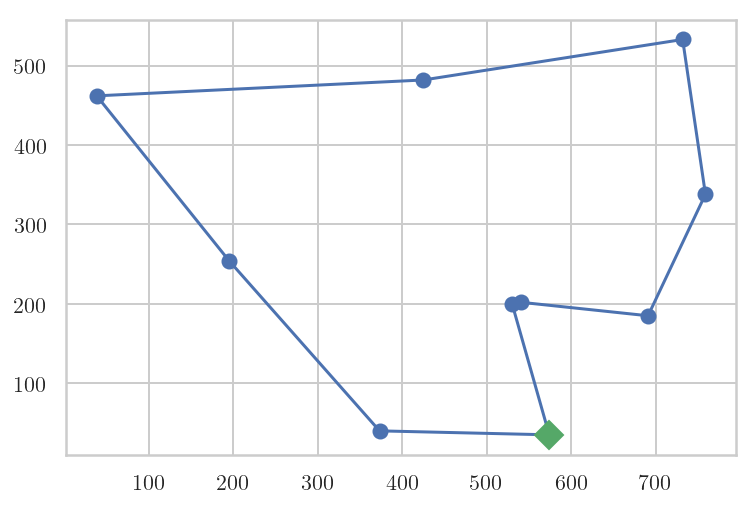

In [330]:
plot_tour(tour)

In [333]:
# The above is an extremely naive means of searching for the shortest path, as it
# doesn't filter through paths which are effectively the same, which the following
# functions do. It also doesnt prioritize any one city over another, so were stuck
# processing all possible results and comparing them instead of making do with what
# we know we have which 

In [394]:
num_cities = 30
cities = generate_cities(num_cities)

In [402]:
type(cities), len(cities), type(list(cities)[0])

(set, 30, complex)

In [ ]:
# Standard base
toolbox = base.Toolbox()
creator.create("DistanceMinimizer", base.Fitness, weights=(-1.0,))
creator.create("Destinations", list, fitness=creator.DistanceMinimizer)

# 'indicies' is used by individual to generate a random permutation of a list of destinations
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Destinations, toolbox.indices)
# 'population' runs individual many times to generate a list of lists of random permutations
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# 'mate' takes two individuals modifies them in place via crossover
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [431]:
# Returns some permutations of values 0 < x < n, here n is 5 
numpy.random.permutation(5)

array([1, 2, 0, 4, 3])

In [434]:
# destinations is some permutation of every value below the length of 
# the number of cities generate earlier, because num_cities was 30
# so is destinations. They serve as an index to our cities list making
# it a symbollic itinerary of which cities to visit in which order, the 
# first two cities are given below:

destinations = toolbox.individual()
type(destinations), len(destinations), destinations[:2]

(deap.creator.Destinations, 30, [27, 28])

In [419]:
# create 10, 30-destination long itineraries, which are random permutations of 
# the values below 30
pop = toolbox.population(n=10)

type(pop), len(pop), type(pop[0]), len(pop[0])

(list, 10, deap.creator.Destinations, 30)

In [441]:
# Given a list of destinations with associated weights and an itinerary of which
# to vist, create a list of said destinations and weights ordered by the itinerary
# so if the first value in the itinerary is 27, the 267th city generated becomes
# the first city to vist
def create_tour(dest_weight_pairs, individual):
    return [list(dest_weight_pairs)[destination] for destination in individual]

# Given a list of destinations with associated weights and an itinerary of which
# to vist, determinte the euclidean distance between each
def evaluation(dest_weight_pairs, individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(dest_weight_pairs, individual)),)

In [442]:
# for example we can take these two sequence destinations
create_tour(cities, destinations)[:2]

[(705+39j), (510+296j)]

In [443]:
# and this is the distance between them
evaluation(cities, destinations)[:1]

(11996.350520667755,)

In [444]:
toolbox.register("evaluate", evaluation, cities)
toolbox.register("select", tools.selTournament, tournsize=3)
pop = toolbox.population(n=100)

In [407]:
%%time

# The effective function of this algorithm is thus to, given the population and the toolbox
# which provides methods for evaluating fitness and selecting out less fit offspring via
# tools.selTournament, which randomly selects k members of the population and returns
# the one which is most fit under the fitness function
result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.9, mutpb=0.1, ngen=1000, verbose=False)

CPU times: user 18.6 s, sys: 325 ms, total: 18.9 s
Wall time: 19.8 s


Fitness of the best individual:  3736.023175019308


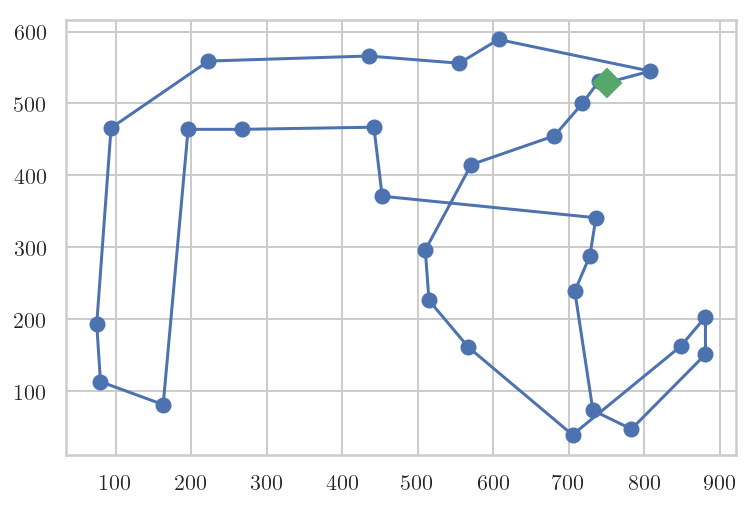

In [413]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(cities, best_individual)[0])
plot_tour(create_tour(cities, best_individual))

In [377]:
%%time

# There are many things you could do to improve this algorithm, one is to do hyperparameter
# search to find which arguments minimize the fitness functions
result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.1, mutpb=0.9,  ngen=1000, verbose=False)

CPU times: user 15.5 s, sys: 171 ms, total: 15.6 s
Wall time: 16 s


Fitness of the best individual:  5682.71002924811


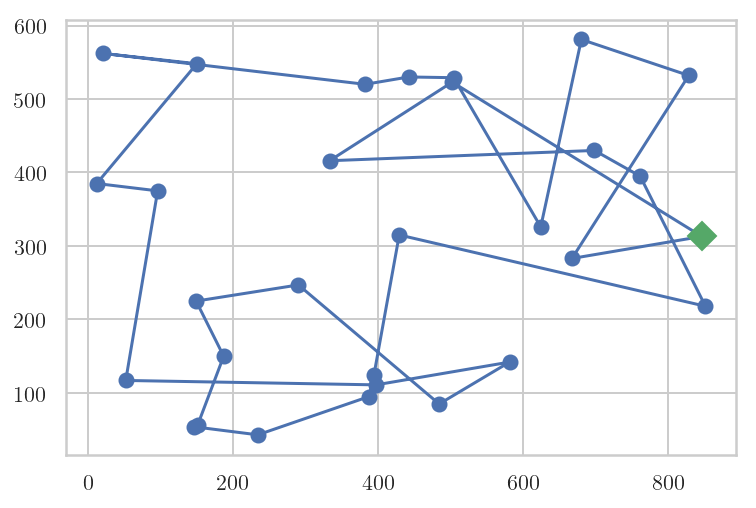

In [378]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])
plot_tour(create_tour(best_individual))

In [379]:
%%time

result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,  ngen=1000, verbose=False)

CPU times: user 14.5 s, sys: 147 ms, total: 14.7 s
Wall time: 15 s


Fitness of the best individual:  3750.0691558856324


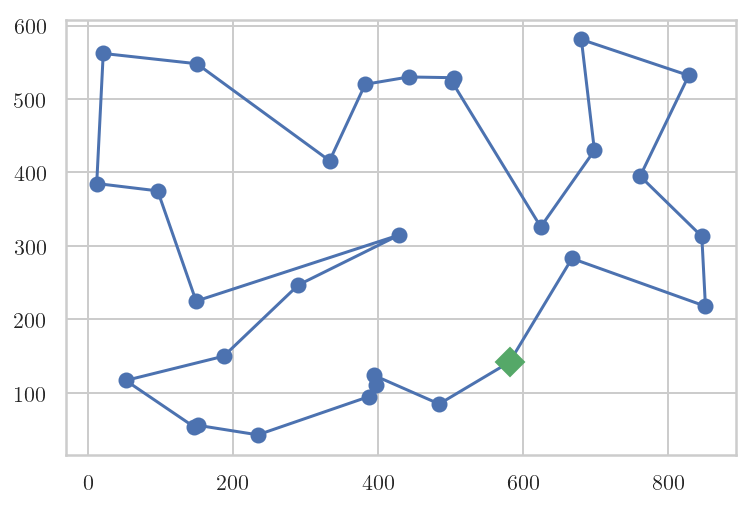

In [380]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])
plot_tour(create_tour(best_individual))

In [381]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', numpy.mean)
fit_stats.register('min', numpy.min)

In [382]:
result, log = algorithms.eaSimple(toolbox.population(n=400), toolbox, cxpb=0.5, mutpb=0.2, ngen=400, verbose=False, stats=fit_stats)

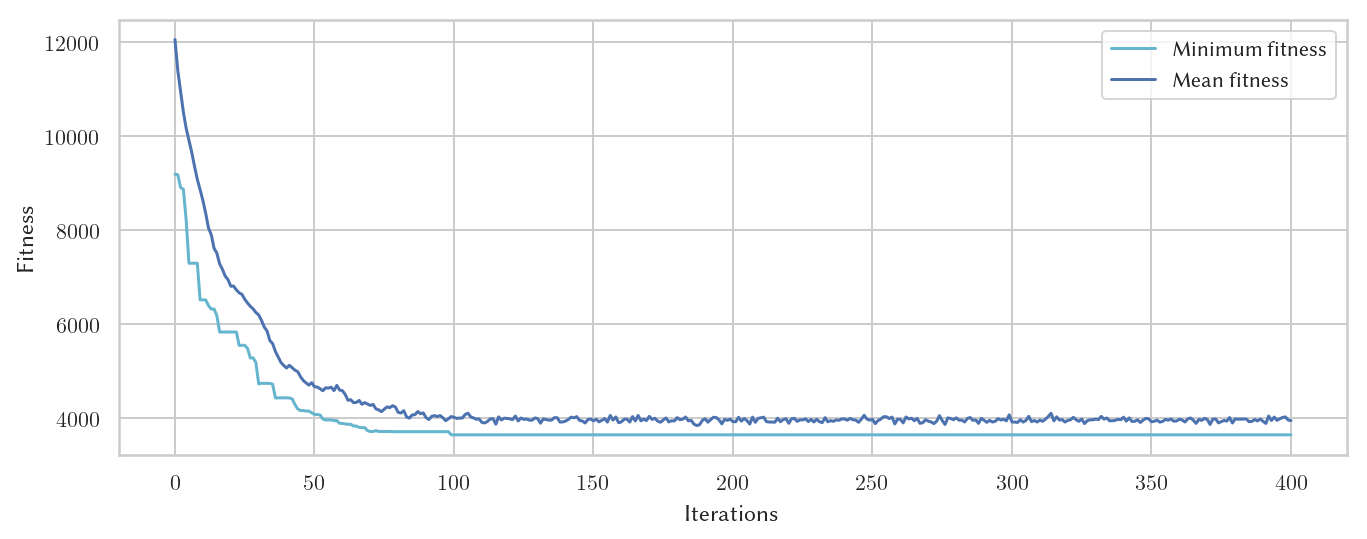

In [383]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

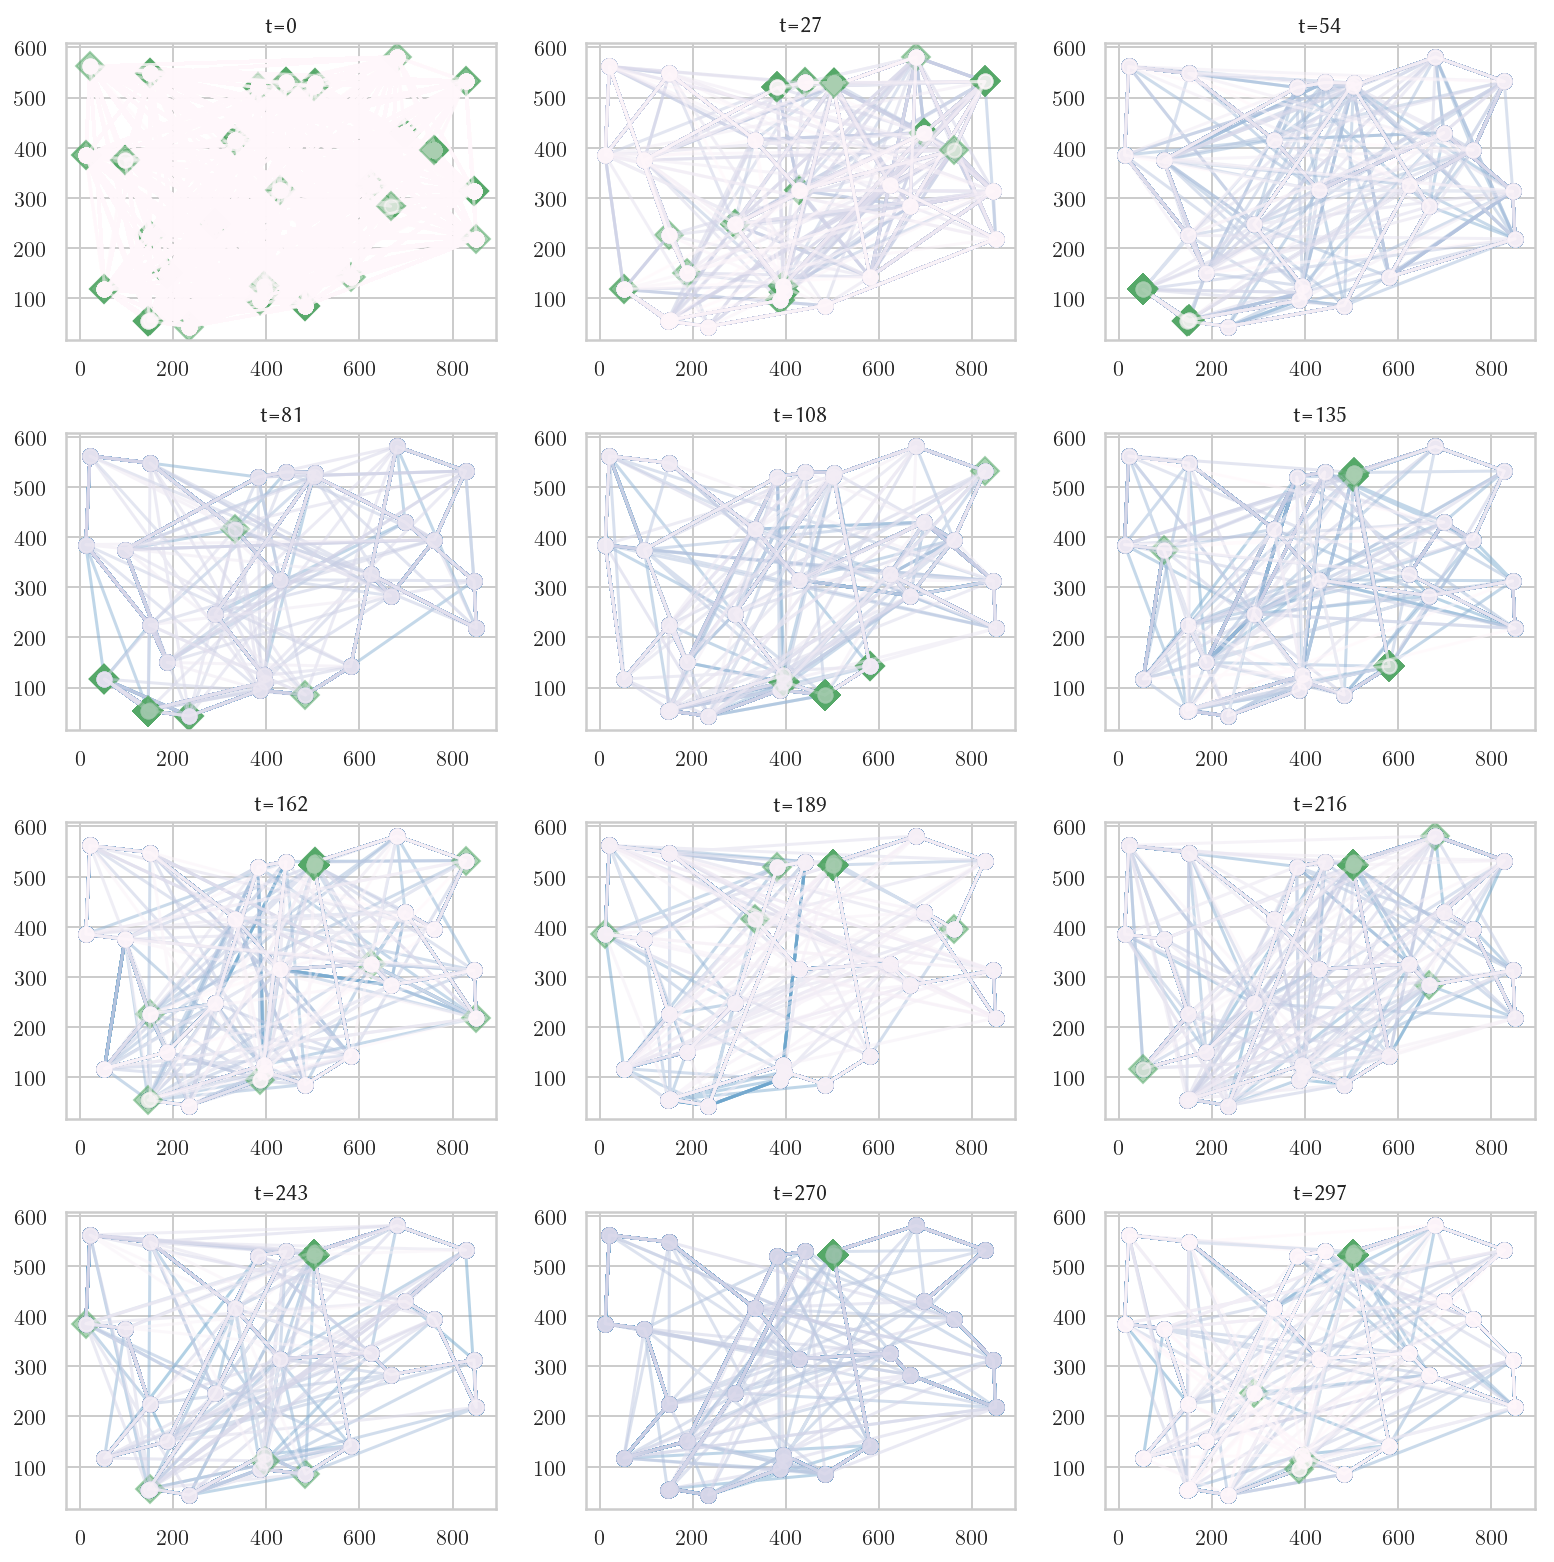

In [384]:
pop_stats = tools.Statistics(key=numpy.copy)
pop_stats.register('pop', numpy.copy) # -- copies the populations themselves
pop_stats.register('fitness', # -- computes and stores the fitnesses
                   lambda x : [evaluation(a) for a in x]) 

result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=pop_stats)

def plot_population(record, min_fitness, max_fitness):
    '''
    Plots all individuals in a population. 
    Darker individuals have a better fitness.
    '''
    pop = record['pop']
    fits = record['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm, 
                            cmap=plt.get_cmap('PuBu'))
    
    for i in range(len(index)):
        color = sm.to_rgba(max_fitness - fits[index[i]][0])
        plot_tour(create_tour(pop[index[i]]), alpha=0.5, color=color)

min_fitness = numpy.min(log.select('fitness'))
max_fitness = numpy.max(log.select('fitness'))

plt.figure(figsize=(11,11))
for i in range(0, 12):
    plt.subplot(4,3,i+1)
    it = int(math.ceil((len(log)-1.)/15))
    plt.title('t=' + str(it*i))
    plot_population(log[it*i], min_fitness, max_fitness)
plt.tight_layout()

In [385]:
from matplotlib import animation
from IPython.display import HTML

def update_plot_tour(plot, points, alpha=1, color='blue'):
    'A function for updating a plot with an individual'
    X, Y = XY(list(points) + [points[0]])
    plot.set_data(X, Y)
    plot.set_color(color)
    return plot

def init():
    'Initialization of all plots to empty data'
    for p in list(tour_plots):
        p.set_data([], [])
    return tour_plots

def animate(i):
    'Updates all plots to match frame _i_ of the animation' 
    pop = log[i]['pop']
    fits = log[i]['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm, 
                            cmap=plt.get_cmap('PuBu'))
    for j in range(len(tour_plots)):
        color = sm.to_rgba(max_fitness - fits[index[j]][0])
        update_plot_tour(tour_plots[j], 
                         create_tour(pop[index[j]]), 
                         alpha=0.5, color=color)
    return tour_plots

fig = plt.figure()
ax = plt.axes(xlim=(0, 900), ylim=(0, 600))
tour_plots = [ax.plot([], [], 'bo-', alpha=0.1) for i in range(len(log[0]['pop']))]
tour_plots = [p[0] for p in tour_plots]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=60, blit=True)
plt.close()

HTML(anim.to_html5_video())

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1. Using a genetic algorithm we were able to find a near-optimal path between the points specified. We generated the points randomly, and assigned them weights at random too. In real-life, typically these weights would indicate the amount of money spent or time taken to travel. From those points we then randomly selected possible paths to take. Said paths were then used as genes for organisms in our genetic algorithm, where each organism, with a different path, was assigned a fitness according to how small it's score was based on it's genes alone. Then using a selection algorithm, we randomly drew 'tourSize' members from the population and selected the best one from each according to the fitness function 'k' times. Using eaSimple we ran the above simulate 'ngen' times, here 1000, giving each organism '0.9' probability of mating - undergoing crossover - and a '0.1' probability of mutation. Over time this selected out organisms from the population which were less fit, leading to a near optimal solution.
2. Making sure my conceptual understanding of what was going on matched what was written.
3. That simulated annealing is capable of performant optimization
4. Probably how far you can take the idea of encoding problems into genes for organisms to duke it out over using various selection algorithms



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about

